#  Прогнозирование заказов такси

# Введение

### Описание проекта 
Проект нацелен на оптимизацию количества активных водителей в периоды пиковых нагрузок на транспортную сеть.
### Цель проекта
Используя данные о заказах такси необходимо построить модель прогнозирования количества заказов такси на последующий час.
### Описание данных
**Нам предоставлены исторические данные компании «Чётенькое такси».**   


**Признаки:**
- datetime - время записи

**Целевой признак:**
- num_orders — число заказов

**Заказчику важны:**

- качество предсказания (RMSE не более 48)

### План работы
1. [Загрузка и подготовка данных](#section_1)  
2. [Анализ данных](#section_2)  
3. [Обучение и анализ моделей](#section_3)
4. [Проверка итоговой модели](#section_4)
5. [Общий вывод](#section_5)

<a id='section_1'></a>
## Загрузка и подготовка данных

Загрузим необходимые библиотеки.

In [1]:
import os
import pandas as pd
import numpy as np

Произведём загрузку датасета.

In [2]:
pth1 = r'C:\Projects\taxi_orders\taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, монотонно ли распределены индексы.

In [4]:
df.index.is_monotonic

True

In [5]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Как мы видим в датасете присутствует только информация о количестве заказов с интервалом в 10 минут.

Проверим данные на пропуски.

In [6]:
df.isna().mean()

num_orders    0.0
dtype: float64

<a id='section_2'></a>
## Анализ данных

Оценим динамику количетсва заказов в день за весь промежуток 2018-03-01 00:00:00 - 2018-08-31 23:50:00

In [7]:
def plot_orders(data, period, interval_start, interval_stop, rolling):
    data = data[interval_start:interval_stop].resample(period).sum()
    data -= data.shift()
    data['mean'] = data['num_orders'].rolling(rolling).mean()
    data['std'] = data['num_orders'].rolling(rolling).std()
    data.plot()

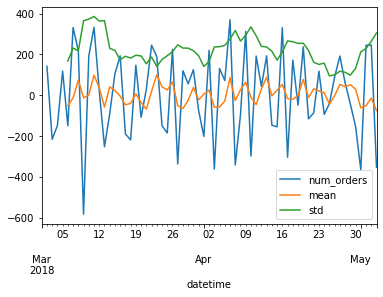

In [8]:
plot_orders(df, '1d', '2018-03-01', '2018-05-04', 5)

Разложиим временной ряд на тренд, сезонность и остаток.

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [10]:
df.sort_index(inplace=True)

In [11]:
decomposed = seasonal_decompose(df['num_orders'].resample('1h').sum())

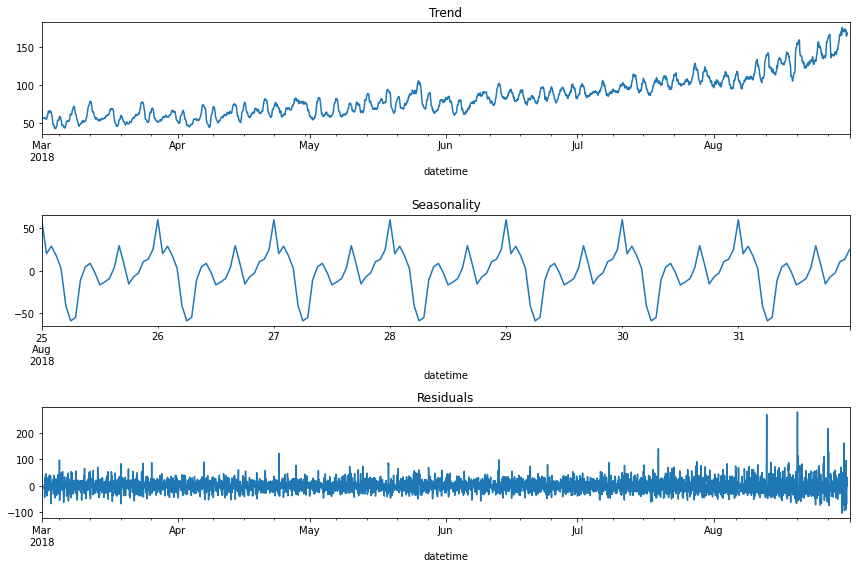

In [12]:
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot()
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.tail(24*7).plot()
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot()
plt.title('Residuals')
plt.tight_layout()

На графиках виден восходящий тренд количества заказов в час, а также устойчивый повторяющийся ежедневный паттерн.

<a id='section_3'></a>
## Обучение и анализ моделей

### Подготовка признаков

Произведём ресемплинг в соответствии с условием задачи.

In [13]:
df = df.resample('1h').sum()

Создадим дополнительные признаки.

In [14]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['is_weekend'] = data['day_of_week'].isin([5,6]) * 1
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [15]:
data = make_features(df, 50, 5)

Удалим строки с пропущенными значениями.

In [16]:
data = data.dropna()

Разделим данные на выборки.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train, valid_test = train_test_split(data, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_valid = valid.drop('num_orders', axis=1)
y_valid = valid['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

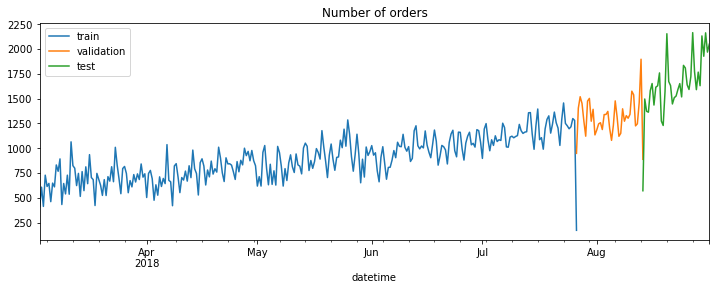

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))
train['num_orders'].resample('12h').sum().plot(ax=ax, label='train')
valid['num_orders'].resample('12h').sum().plot(ax=ax, label='validation')
test['num_orders'].resample('12h').sum().plot(ax=ax, label='test')
ax.set_title('Number of orders')
ax.legend()

Данные разделены в соотношении 8:1:1.

In [20]:
test.shape

(437, 57)

In [21]:
data.head()

,num_orders,month,day,day_of_week,hour,is_weekend,lag_1,lag_2,lag_3,lag_4,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,3,3,5,2,1,108.0,163.0,72.0,119.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,112.6
2018-03-03 03:00:00,64,3,3,5,3,1,25.0,108.0,163.0,72.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,97.4
2018-03-03 04:00:00,44,3,3,5,4,1,64.0,25.0,108.0,163.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,86.4
2018-03-03 05:00:00,15,3,3,5,5,1,44.0,64.0,25.0,108.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,80.8
2018-03-03 06:00:00,9,3,3,5,6,1,15.0,44.0,64.0,25.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,51.2


### Запись результатов моделей на валидационной выборке

Функция для расчёта результатов.

In [22]:
def model_score(model, X_valid, y_valid):
    
    y_pred = model.predict(X_valid)
        
    return mean_squared_error(y_valid, y_pred, squared=False)

Список для записи результатов.

In [23]:
results = []

### Линейная регрессия

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [25]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)
    
    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold, squared=False)        
 
    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [26]:
lr = LinearRegression()

In [27]:
performTimeSeriesCV(X_train, y_train, 5, lr, mean_squared_error)

Size train set: (3492, 56)
Size of each fold: 698

Splitting the first 2 chunks at 1/2
Size of train + test: (1396, 56)

Splitting the first 3 chunks at 2/3
Size of train + test: (2094, 56)

Splitting the first 4 chunks at 3/4
Size of train + test: (2792, 56)

Splitting the first 5 chunks at 4/5
Size of train + test: (3490, 56)


24.712734786390094

In [28]:
results.append(model_score(lr, X_valid, y_valid))

### CatBoost

In [29]:
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

Для кросс-валидации будет использован специальный инструмент библиотеки sklearn для временных рядов.

In [30]:
tscv = TimeSeriesSplit(n_splits=3)

In [31]:
cat_features = ['month', 'day', 'day_of_week', 'hour', 'is_weekend']

model = CatBoostRegressor(loss_function='RMSE', 
                          cat_features=cat_features, 
                          verbose=0,
                          random_state=12345)

params = {'learning_rate': [0.1, 0.3, 0.5],
          'iterations': [50, 100],
          'depth': [1, 5, 7, 10],}

In [32]:
cb_gs = GridSearchCV(model,
                      params,
                      cv=tscv,
                      scoring='neg_root_mean_squared_error',
                      verbose=0)
cb_gs.fit(X_train, y_train)
cb_gs.best_params_

{'depth': 5, 'iterations': 100, 'learning_rate': 0.1}

In [33]:
results.append(model_score(cb_gs.best_estimator_, X_valid, y_valid))

### RandomForest

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV

In [35]:
X_train_rf = X_train.copy()
X_valid_rf = X_valid.copy()
X_test_rf = X_test.copy()

In [36]:
num_features = data.columns.difference(cat_features)

Отмасштабируем численные переменные.

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
scaler = StandardScaler()
X_train_rf = scaler.fit_transform(X_train_rf)
X_valid_rf = scaler.transform(X_valid_rf)
X_test_rf = scaler.transform(X_test_rf)

In [39]:
model = RandomForestRegressor()

params = {'max_depth': [1, 5, 10, 15],
          'n_estimators': [10, 50, 100],
          'min_samples_split': [2, 5, 7],
          'min_samples_leaf': [1, 5, 7],
         }

rf_hrs = HalvingRandomSearchCV(model,
                               params,
                               cv=tscv,
                               scoring='neg_root_mean_squared_error',
                               verbose=0,
                               n_jobs=-1,
                               random_state=12345)

rf_hrs.fit(X_train_rf, y_train)
rf_hrs.best_params_

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 108 is smaller than n_iter=582. Running 108 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_estimators': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 10}

In [40]:
results.append(model_score(rf_hrs.best_estimator_, X_valid_rf, y_valid))

### LightGBM

In [41]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [42]:
X_train_lgbm = X_train.copy()
X_valid_lgbm = X_valid.copy()
X_test_lgbm = X_test.copy()
for c in cat_features:
    X_train_lgbm[c] = X_train_lgbm[c].astype('category')
    X_valid_lgbm[c] = X_valid_lgbm[c].astype('category')
    X_test_lgbm[c] = X_test_lgbm[c].astype('category')

In [43]:
model = LGBMRegressor(random_state=12345)

params = {
    'objective': ['regression'],
    'metric': ['RMSE'],
    'num_leaves': [31, 50, 75],
    'learning_rate': [0.05, 0.1, 0.2],
    'feature_fraction': [0.5, 0.7, 0.9]
}

lgbm_gs = GridSearchCV(
    model, 
    params, 
    cv=tscv, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

lgbm_gs.fit(X_train_lgbm, y_train)
lgbm_gs.best_params_

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


{'feature_fraction': 0.5,
 'learning_rate': 0.1,
 'metric': 'RMSE',
 'num_leaves': 31,
 'objective': 'regression'}

In [44]:
results.append(model_score(lgbm_gs.best_estimator_, X_valid_lgbm, y_valid))

### Сравнение результатов моделей

In [45]:
index=['LinearRegression', 'CatBoost', 'RandomForest', 'LightGBM']
model_comparison = pd.DataFrame(results, index=index, columns=['RMSE'])
model_comparison.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col]).format('{:.2f}')

,RMSE
LinearRegression,32.24
CatBoost,32.18
RandomForest,32.38
LightGBM,30.64


Наилучший результат на валидационной выборке показала модель LightGBM.

<a id='section_4'></a>
## Проверка итоговой модели

### Проверка на тестовой выборке

Протестируем наилучшую модель на тестовой выборке.

In [46]:
pd.concat([X_train_lgbm, X_valid_lgbm]).dtypes.head()

month             int64
day               int64
day_of_week    category
hour           category
is_weekend     category
dtype: object

Дополним модель новыми данными для тренировки.

In [47]:
X_train_valid_lgbm = pd.concat([X_train_lgbm, X_valid_lgbm])

y_train_valid_lgbm = pd.concat([y_train, y_valid])

for c in cat_features:
    X_train_valid_lgbm[c] = X_train_valid_lgbm[c].astype('category')

In [48]:
best_model = lgbm_gs.best_estimator_
best_model.fit(X_train_valid_lgbm, y_train_valid_lgbm)

y_pred = best_model.predict(X_test_lgbm)

print('Финальный RMSE:', mean_squared_error(y_test, y_pred, squared=False))

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
Финальный RMSE: 38.580040429510994


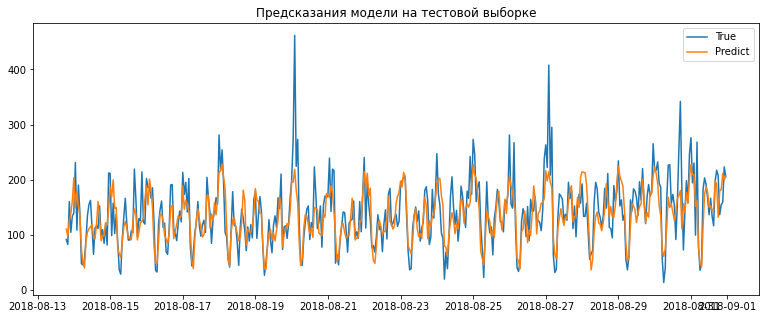

In [49]:
plt.figure(figsize=(13, 5))

plt.plot(y_test, label='True')
plt.plot(y_test.index, y_pred, label='Predict')

plt.title('Предсказания модели на тестовой выборке')

plt.legend()
plt.show()

### Проверка на адекватность

Произведём проверку на адекватность с помощью константной модели.

In [50]:
from sklearn.dummy import DummyRegressor

In [51]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train_valid_lgbm, y_train_valid_lgbm)
y_pred = dummy.predict(X_test_lgbm)
print('Dummy RMSE:', mean_squared_error(y_test, y_pred, squared=False))

Dummy RMSE: 84.7599140370457


Модель показала значительно лучшие результаты, чем у константной модели.

<a id='section_5'></a>
## Общий вывод

В ходе исследования были обработаны и проанализированы данные о количестве заказов такси, созданы модели предсказания заказов, а также сделаны выводы.   
После проделанной работы можно выделить алгоритм LightGBM, который по совокупности результатов занимает первое место в списке моделей машинного обучения.

**После проделанного исследования можно сделать следующие выводы:**

1. Выявлен восходящий тренд количства заказов такси.
2. Лучшее качество продемонстрировала модель LightGBM.
3. Финальный RMSE составляет: 38.58